# Basic XCast Example

The following cell loads sample datasets from XCast - X is  NMME GCM forecasts, and Y is India Meteorological Department precipitation observations. T is Y, but one-hot encoded into tercile categories according the the 33rd and 66th percentiles of rainfall at each gridpoint

In [1]:
import xcast as xc 
X, Y, T = xc.load_sample_data()

/Users/kylehall/opt/anaconda3/envs/xcast/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/kylehall/opt/anaconda3/envs/xcast/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [2]:
X

<xarray.DataArray 'prec' (M: 11, S: 37, Y: 129, X: 135)>
dask.array<open_dataset-14bf87cefc00aecf01cf8eb2f27cf680prec, shape=(11, 37, 129, 135), dtype=float64, chunksize=(11, 37, 129, 135), chunktype=numpy.ndarray>
Coordinates:
  * Y        (Y) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
  * X        (X) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
  * M        (M) object 'CANCM3' 'CANCM4' 'CANCM4I' ... 'NASA-GEOS' 'NCEP-CFSV2'
  * S        (S) datetime64[ns] 1982-05-01 1983-05-01 ... 2017-05-01 2018-05-01
Attributes:
    generated_by:  \n  XCAST regridded

In [3]:
Y

<xarray.DataArray 'rf' (M: 1, T: 37, Y: 129, X: 135)>
dask.array<open_dataset-53e02b4c14b5be3b1fbe85c62f3ae505rf, shape=(1, 37, 129, 135), dtype=float32, chunksize=(1, 37, 129, 135), chunktype=numpy.ndarray>
Coordinates:
  * M        (M) int64 0
  * X        (X) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
  * Y        (Y) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
  * T        (T) datetime64[ns] 1982-06-01 1983-06-01 ... 2017-06-01 2018-06-01

In [4]:
T

<xarray.DataArray 'rf' (M: 3, T: 37, Y: 129, X: 135)>
dask.array<mul, shape=(3, 37, 129, 135), dtype=float32, chunksize=(1, 37, 129, 135), chunktype=numpy.ndarray>
Coordinates:
  * M        (M) <U2 'BN' 'NN' 'AN'
  * X        (X) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
  * Y        (Y) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
  * T        (T) datetime64[ns] 1982-06-01 1983-06-01 ... 2017-06-01 2018-06-01
Attributes:
    generated_by:  \n  XCAST Ranked Tercile One-Hot Encoded

# Fit-Predict 

The following cell fits a multiple linear regression (MLR) on the data, at each gridpoint across X and Y. this Literally uses the Scikit-Learn implementation of MLR at each grid point (129 x 135, so like ~10000 separate calls to MLR). Note that whatever variables are in the "M" dimension on X will be used as separate predictor variables, and whatever are separate along the "T" or "S" dimension will be used as separate training samples. **Note that X and Y here MUST have the SAME resolution/size, exactly along X and Y, and also T** the actual coordinates will be ignored, so make sure your data are lined up! 

In [5]:
# Note that X and Y here must have 
mlr = xc.rMultipleLinearRegression()
mlr.fit(X, Y)
preds = mlr.predict(X)

In [6]:
preds

<xarray.DataArray 'predicted' (Y: 129, X: 135, ND: 1, S: 37, M: 1)>
dask.array<apply_predict_to_block, shape=(129, 135, 1, 37, 1), dtype=float64, chunksize=(129, 135, 1, 37, 1), chunktype=numpy.ndarray>
Coordinates:
  * Y        (Y) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
  * X        (X) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
  * S        (S) datetime64[ns] 1982-05-01 1983-05-01 ... 2017-05-01 2018-05-01
  * M        (M) int64 0
  * ND       (ND) int64 0
Attributes:
    generated_by:  XCast Classifier - <class 'sklearn.linear_model._base.Line...

**NOTE** see how `preds` has 5th dimension - `ND`? that is because some XCast methods are stochastic, and are required to be run as ensembles of multiple stochastically initialized ML models (like, ELM or Random Forest or ANN). If you set ND=30 in the xc.rMultipleLinearRegression, XCast will execute the fit-predict 30 times with random initializations. for MLR it doesn't matter though! (if you do use ND=30, or ND=4, or whatever, you should then use `preds.mean('ND')` 

# Evaluating Predictions with Skill Metrics 
This cell compares predicted data to the target that the AI/ML model was supposed to learn to recreate. Here we use Pearsons Correlation Coefficient with XCast (this uses the SciPy implementation and works just like the fit-predict- everything must be lined up!) 

In [7]:
pearson = xc.Pearson(preds.mean('ND'), Y)
pearson

/Users/kylehall/opt/anaconda3/envs/xcast/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


<xarray.DataArray 'Pearson' (Y: 129, X: 135, M: 1, SKILLDIM: 1)>
array([[[[nan]],

        [[nan]],

        [[nan]],

        ...,

        [[nan]],

        [[nan]],

        [[nan]]],


       [[[nan]],

        [[nan]],

        [[nan]],
...
        [[nan]],

        [[nan]],

        [[nan]]],


       [[[nan]],

        [[nan]],

        [[nan]],

        ...,

        [[nan]],

        [[nan]],

        [[nan]]]])
Coordinates:
  * Y         (Y) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
  * X         (X) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
  * M         (M) int64 0
  * SKILLDIM  (SKILLDIM) int64 0

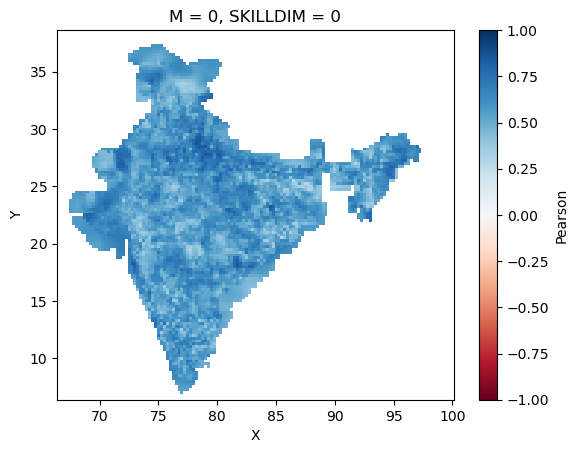

In [9]:
pearson.plot(vmin=-1, vmax=1, cmap='RdBu')

Since this was totally outside of validation - it did pretty well! Cross validation will be covered in another notebook